## Imports

In [1]:
import pickle
import tseval.feature_extraction
from scipy.stats import spearmanr
#import math

import numpy as np

import spacy
mod = spacy.load("de_core_news_sm")

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from keras.callbacks import ModelCheckpoint

import csv

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

## Linear regression

In [3]:
# Load dataset, create features

score = []
sentence = []
with open("data_training.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        sentence.append(row[1])
        score.append(row[2])

In [4]:
scores = [float(s) for s in score[1:]]

In [5]:
def get_feature_values(spacy_model, simple_sent, chosen_functions=None, lang="de", only_names=False):
    # chosen_functions is list of indices of functions that should be used to calculate features
    
    feature_list = list()
    all_sentence_functions = tseval.feature_extraction.get_sentence_simplification_feature_extractors()   + tseval.feature_extraction.get_sentence_feature_extractors()
    #all_pair_functions = tseval.feature_extraction.get_sentence_pair_simplification_feature_extractors()   + tseval.feature_extraction.get_sentence_pair_feature_extractors()
    if type(chosen_functions) == 'list':
        all_sentence_functions = [all_sentence_functions[i] for i in chosen_functions]
    
    if only_names:
        names_list = list()
        for func in all_sentence_functions:
            # print(func.__name__)
            names_list.append(func.__name__+"_complex")
            names_list.append(func.__name__+"_simple")
        for func in all_pair_functions:
            names_list.append(func.__name__+"_paired")
        return names_list

    simple_sent = spacy_model(simple_sent.lstrip().rstrip())
    for func in all_sentence_functions:
        #feature_list.append(str(func(complex_sent, lang)))
        feature_list.append(str(func(simple_sent, lang)))
    #for func in all_pair_functions:
        # print(func.__name__)
        #feature_list.append(str(func(complex_sent, simple_sent, lang)))
    # print(feature_list, )
    
    
    
    feature_list = convert_features(feature_list)
    
    return feature_list

In [6]:
def convert_features(ft_list):
    conv = list()
    for g in ft_list:

        if g == 'True':
            conv.append(0.9)
        elif g == 'False':
            conv.append(0.1)
        #elif math.isnan(g) == True:
        elif g == 'nan':
            conv.append(0.0)
        else:
            conv.append(float(g))
        #converted_feats.append(conv)
        
    return conv

In [7]:
best_feats = list()
for sent in sentence[1:]:
    best_feats.append(get_feature_values(mod, sent))

/Users/freya.hewett/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/freya.hewett/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loading de FastText embeddings...
Done.


In [8]:
fts = np.array(best_feats)

In [9]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=34, step=1)
selector = selector.fit(fts, scores)
ranks = selector.ranking_
chosen_features = np.where(ranks<2)

In [10]:
all_sentence_functions = tseval.feature_extraction.get_sentence_simplification_feature_extractors()   + tseval.feature_extraction.get_sentence_feature_extractors()

In [15]:
# These are the features
feat_names = list()

for n in list(chosen_features[0]):
    #print(n)
    print(str(all_sentence_functions[n]).split(' ')[1])
    feat_names.append(str(all_sentence_functions[n]).split(' ')[1])

get_type_token_ratio
get_ratio_of_function_words
get_ratio_of_coordinating_clauses
get_ratio_of_subordinate_clauses
get_ratio_prepositional_phrases
get_ratio_relative_phrases
get_ratio_clauses
get_ratio_named_entities
check_if_head_is_noun
check_if_one_child_of_root_is_subject
check_passive_voice
is_non_projective
get_ratio_of_nouns
get_ratio_of_verbs
get_ratio_of_adjectives
get_ratio_of_adpositions
get_ratio_of_adverbs
get_ratio_of_auxiliary_verbs
get_ratio_of_conjunctions
get_ratio_of_determiners
get_ratio_of_numerals
get_ratio_of_particles
get_ratio_of_pronouns
get_ratio_of_punctuation
count_words
count_sentences
count_syllables_in_sentence
count_words_per_sentence
count_syllables_per_sentence
count_characters_per_word
count_syllables_per_word
max_pos_in_freq_table
average_pos_in_freq_table
sentence_fkgl


In [12]:
X_train, X_test, y_train, y_test = train_test_split(fts[:,chosen_features[0]], scores, test_size=0.2, random_state=42, shuffle=True)
reg = LinearRegression().fit(X_train, y_train)
preds = reg.predict(X_test)
print(mean_squared_error(y_test, preds, squared=False))

0.7009478824655395


## Best features

In [13]:
# Get best features
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), LinearRegression())

model.fit(X_train, y_train)

model score on training data: 0.6874388151306339
model score on testing data: 0.6842628528820357


In [17]:
model[1].coef_

array([-0.07256279,  0.07227218,  0.24627829, -0.20046258, -0.00651179,
        0.08803189, -0.03064914, -0.13728341, -0.00283254,  0.04796443,
        0.03888378,  0.03128823,  0.05582192,  0.01005928,  0.15229072,
        0.22736639,  0.16415245,  0.01139531,  0.15309674,  0.2243266 ,
        0.03335174,  0.06017315,  0.13143554,  0.22439079, -0.37001634,
        0.00921485,  1.35485203,  0.55831363, -0.59829988,  0.39198389,
       -0.08846154,  0.15496593,  0.27157909, -0.41492367])

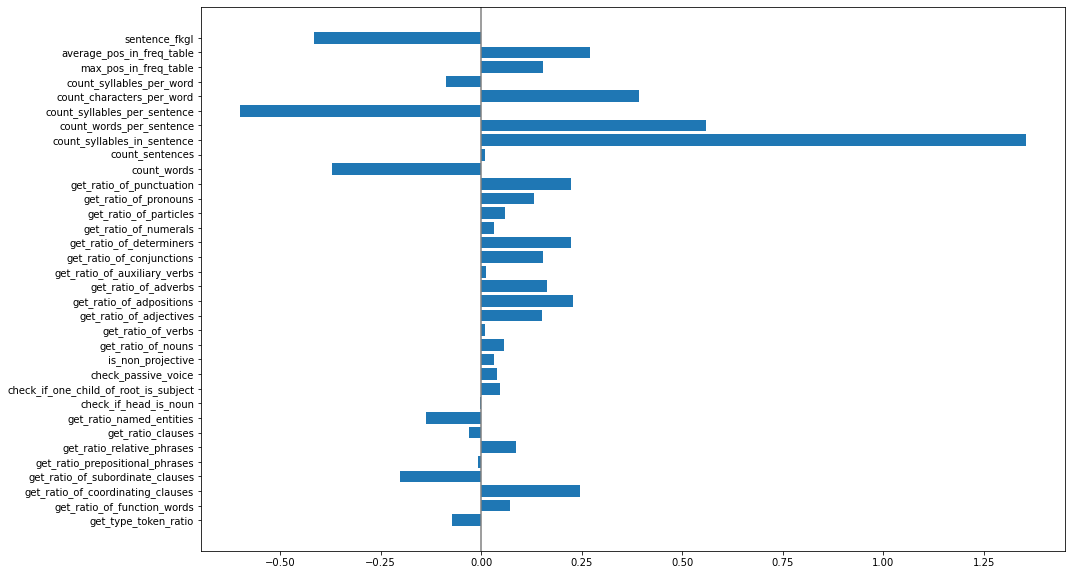

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.barh(feat_names, model[1].coef_)
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)